# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,          
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 32, 
        'num_classes': 2,
        'categorical_indices': [],
        'random_parameters_distribution': True, ##MAKEPATH DIFFERENT FILES
        'max_distributions_per_class': 1, # None; 0; int >= 1
        'exclude_linearly_seperable': True,
        'data_generation_filtering': False,
        'fixed_class_probability': True,
        'weighted_data_generation': True,
        'shift_distrib': True,
        
        'function_generation_type': 'distribution' ,#'distribution', 'distribution_trained' 'make_classification_distribution', 'make_classification_distribution_trained', 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'distribution_list': ['uniform', 'normal', 'gamma', 'beta', 'poisson'],#['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'], 
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
        
        'data_noise': 0, #None or float
        'distrib_param_max': 5,
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-3,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'use_batchnorm_lambda': False,
        
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
                
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    'evaluation': {   
    },    
    
    'computation':{
        'n_jobs': 20,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


#import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(config)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

0it [00:00, ?it/s]

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets10000_var32_class2_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_weightedFeatures_exLinSep_shiftedun-no-ga-be-po_depth3_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets10000_var32_class2_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_weightedFeatures_exLinSep_shiftedun-no-ga-be-po_depth3_beta1_decisionSpars1_vanilla_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[128]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
try:
    path_distribution = './data/saved_function_lists/distribution_parameter_list_list_' + path_identifier_function_data + '.pkl'
    with open(path_distribution, 'rb') as f:
        distribution_parameter_list_list = pickle.load(f)
except Exception:
    traceback.print_exc()
    distribution_parameter_list_list = [[None, None]]*number_of_generated_datasets
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    try:
        distribution_parameter_list_list = random.sample(distribution_parameter_list_list, number_of_trained_lambda_nets)
        random.seed(RANDOM_SEED)
    except:
        distribution_parameter_list_list = [[None, None]]*number_of_trained_lambda_nets

Traceback (most recent call last):
  File "/tmp/ipykernel_828853/2645396674.py", line 14, in <module>
    with open(path_distribution, 'rb') as f:
OSError: [Errno 36] File name too long: './data/saved_function_lists/distribution_parameter_list_list_lNetSize5000_numDatasets10000_var32_class2_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_weightedFeatures_exLinSep_shiftedun-no-ga-be-po_depth3_beta1_decisionSpars1_vanilla_fullyGrown.pkl'


## Data Inspection

In [10]:
function_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,split0,split1,split2,split3,split4,split5,split6,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
X_data_list[0][0].head(10)

feat0     0
feat1     0
feat2     0
feat3     0
feat4     0
feat5     0
feat6     0
split0    0
split1    0
split2    0
dtype: int64

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31
0,0.200,0.458,0.280,0.786,0.603,0.830,0.698,0.610,0.000,0.469,0.000,0.829,0.011,0.177,0.942,0.287,0.545,0.747,0.080,0.087,0.569,0.072,0.446,0.112,0.528,0.095,0.308,0.392,0.074,0.170,0.414,0.036
1,0.300,0.514,0.700,0.824,0.583,0.809,0.564,0.158,0.008,0.812,0.000,0.957,0.212,0.722,0.890,0.233,0.542,0.125,0.095,0.236,0.355,0.949,0.580,0.222,0.178,0.078,0.231,0.717,0.249,0.834,0.114,0.107
2,0.200,0.520,0.390,0.304,0.273,0.084,0.644,0.246,0.000,0.176,0.000,0.078,0.047,0.193,0.972,0.224,0.360,0.088,0.300,0.174,0.446,0.026,0.692,0.726,0.318,0.083,0.077,0.427,0.132,0.040,0.111,0.039
3,0.700,0.539,0.565,0.412,0.942,0.044,0.476,0.402,0.001,0.418,0.000,0.375,0.019,0.881,0.270,0.039,0.475,0.027,0.241,0.260,0.231,0.112,0.542,0.338,0.158,0.192,0.231,0.801,0.239,0.157,0.090,0.390
4,0.000,0.534,0.614,0.214,0.400,0.397,0.366,0.852,0.000,0.889,0.000,0.320,0.056,0.367,0.489,0.063,0.430,0.850,0.120,0.381,0.524,0.291,0.456,0.756,0.795,0.003,0.308,0.711,0.555,0.701,0.058,0.054
5,0.200,0.424,0.645,0.310,0.888,0.076,0.349,0.437,0.076,0.853,0.000,0.750,0.011,0.649,0.898,0.546,0.588,0.216,0.060,0.459,0.415,0.032,0.658,0.907,0.091,0.026,0.308,0.268,0.060,0.914,0.128,0.066
6,0.400,0.521,0.625,0.734,0.922,0.162,0.263,0.310,0.000,0.316,0.000,0.424,0.003,0.492,0.987,0.631,0.709,0.201,0.105,0.269,0.523,0.005,0.598,0.276,0.344,0.256,0.385,0.422,0.075,0.417,0.094,0.032
7,0.100,0.540,0.680,0.821,0.754,0.655,0.544,0.898,0.049,0.368,0.000,0.925,0.071,0.009,0.976,0.083,0.635,0.435,0.234,0.112,0.334,0.055,0.548,0.742,0.064,0.159,0.231,0.844,0.143,0.712,0.164,0.155
8,0.200,0.450,0.460,0.778,0.719,0.246,0.611,0.495,0.018,0.899,0.000,0.149,0.004,0.437,0.002,0.322,0.491,0.246,0.225,0.121,0.616,0.086,0.454,0.055,0.224,0.079,0.154,0.302,0.182,0.215,0.153,0.990
9,0.300,0.387,0.353,0.996,0.254,0.074,0.699,0.652,0.001,0.498,0.000,0.449,0.000,0.987,0.040,0.190,0.500,0.553,0.130,0.089,0.427,0.085,0.581,0.170,0.407,0.218,0.231,0.813,0.034,0.498,0.142,0.009


In [13]:
y_data_list[0][0].head(10)

feat0     0
feat1     0
feat2     0
feat3     0
feat4     0
feat5     0
feat6     0
split0    0
split1    0
split2    0
dtype: int64

In [14]:
y_data_list[0][1].head(10)

,result
0,0.000
1,1.000
2,1.000
3,0.000
4,0.000
5,1.000
6,0.000
7,1.000
8,1.000
9,0.000


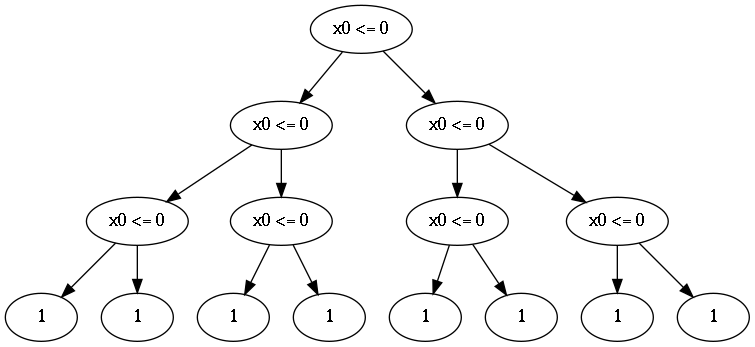

In [15]:
plot = None
if plot_tree_from_parameters != 'make_classification':
    plot = plot_tree_from_parameters(y_data_list[0][0].values, config)
plot

In [16]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [17]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [18]:
y_data_list[0][0].head(10)

feat0     0
feat1     0
feat2     0
feat3     0
feat4     0
feat5     0
feat6     0
split0    0
split1    0
split2    0
dtype: int64

In [19]:
y_data_list[0][0]

feat0     0
feat1     0
feat2     0
feat3     0
feat4     0
feat5     0
feat6     0
split0    0
split1    0
split2    0
split3    0
split4    0
split5    0
split6    0
lp0       0
lp1       0
lp2       0
lp3       0
lp4       0
lp5       0
lp6       0
lp7       0
dtype: int64

In [20]:
y_data_list[0][1].head(10)

,result
0,0.000
1,1.000
2,1.000
3,0.000
4,0.000
5,1.000
6,0.000
7,1.000
8,1.000
9,0.000


## Lambda Network Training + Weigh/Bias saving

In [21]:
#%load_ext autoreload

In [22]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

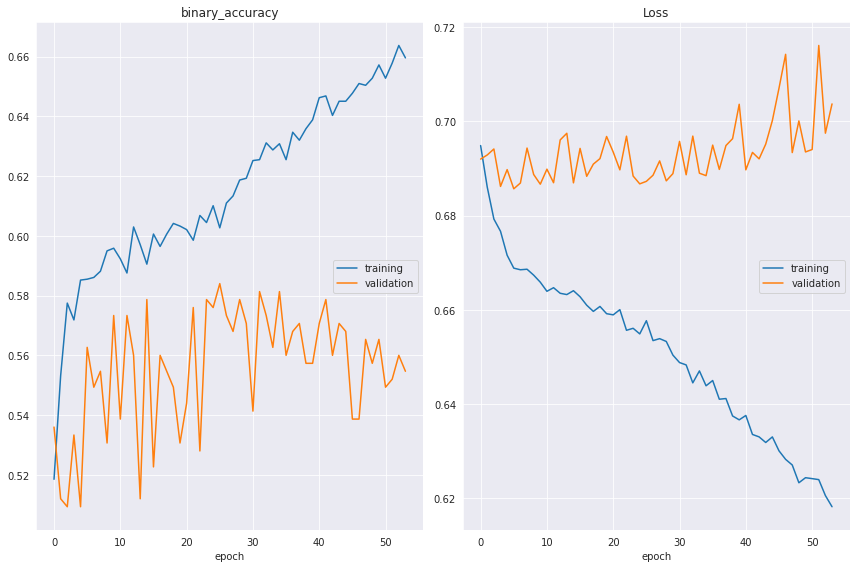

binary_accuracy
	training         	 (min:    0.519, max:    0.664, cur:    0.660)
	validation       	 (min:    0.509, max:    0.584, cur:    0.555)
Loss
	training         	 (min:    0.618, max:    0.695, cur:    0.618)
	validation       	 (min:    0.686, max:    0.716, cur:    0.704)


In [23]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  distribution_parameter_list = distribution_parameter_list_list[rand_index][1],
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

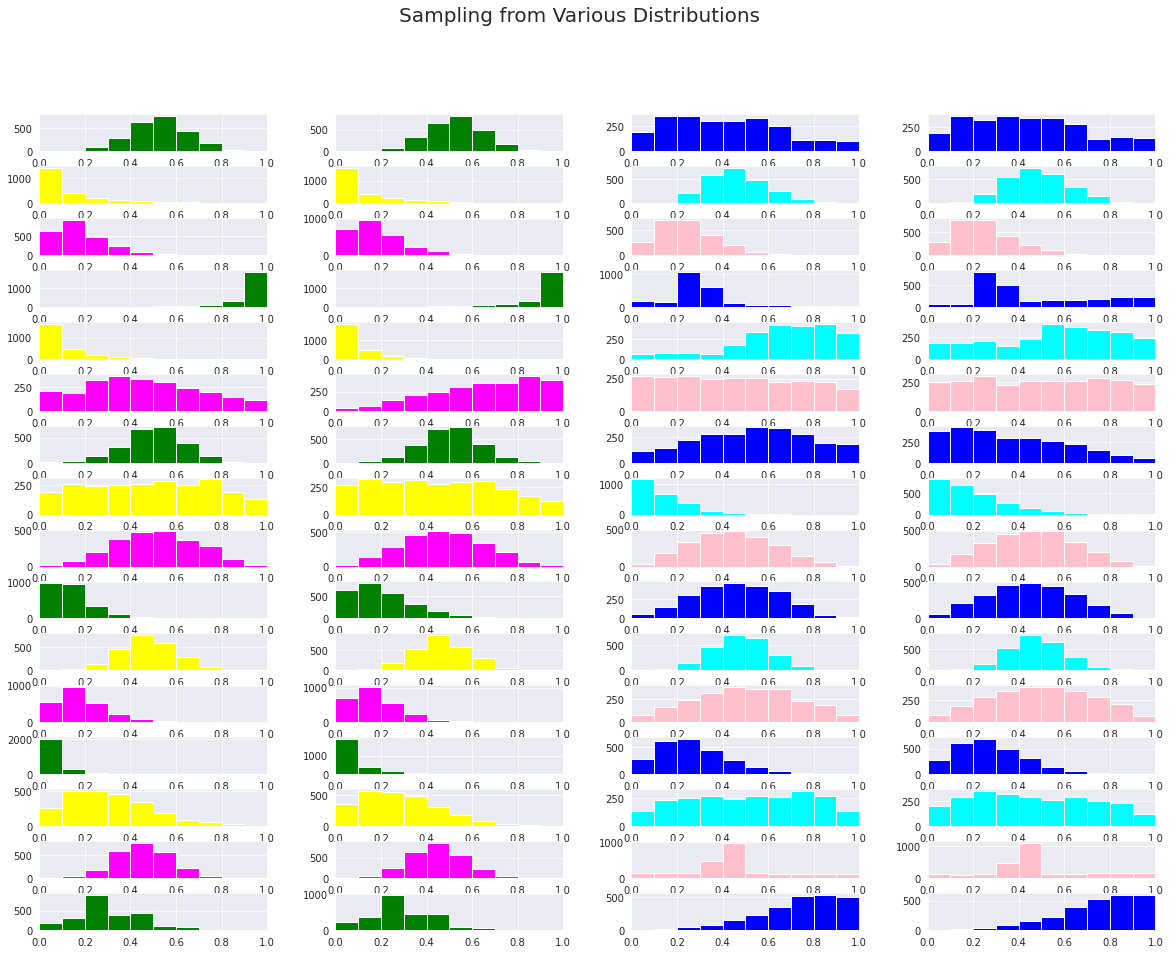

In [24]:
colors_list = ['green','blue','yellow','cyan','magenta','pink']

if config['data']['number_of_variables'] > 4:
    fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/4).astype(int), ncols=4,figsize=(20,15))
else:
    fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/2).astype(int), ncols=2,figsize=(20,15))

for axis_1 in ax:
    for axis_2 in axis_1:
        axis_2.set_xlim([0, 1])                          

plot_index = 0

for i in range(X_data_list[rand_index][1].values.shape[1]):
    colors = colors_list[i%6]

    x = X_data_list[rand_index][1].values[:,i][np.where(random_network['model'].predict(X_data_list[rand_index][1].values).ravel()<=0.5)]
    plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
    plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
    #plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
    plot_index += 1

    x = X_data_list[rand_index][1].values[:,i][np.where(random_network['model'].predict(X_data_list[rand_index][1].values).ravel()>0.5)]
    plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int),4,plot_index+1)
    plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
    #plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
    plot_index += 1

fig.subplots_adjust(hspace=0.4,wspace=.3) 
plt.suptitle('Sampling from Various Distributions',fontsize=20)
plt.show()

In [25]:
distribution_parameter_list_list[0][1]

In [26]:
#%load_ext autoreload
#%autoreload 2

In [27]:
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              distribution_parameter_list=distribution_parameter_list[1],
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data, distribution_parameter_list) in enumerate(zip(X_data_list, y_data_list, distribution_parameter_list_list)))  
del parallel

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:  1.3min
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:  2.9min
[Parallel(n_jobs=20)]: Done 472 tasks      | elapsed:  5.0min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  7.9min
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed: 17.1min
[Parallel(n_jobs=20)]: Done 1528 tasks      | elapsed: 22.4min
[Parallel(n_jobs=20)]: Done 2008 tasks      | elapsed: 29.3min
[Parallel(n_jobs=20)]: Done 2552 tasks      | elapsed: 35.9min
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed: 44.1min
[Parallel(n_jobs=20)]: Done 3832 tasks      | elapsed: 53.0min
[Parallel(n_jobs=20)]: Done 4568 tasks      | elapsed: 63.0min
[Parallel(n_jobs=20)]: Done 5368 tasks      | elapsed: 73.8min
[Parallel(n_jobs=20)]: Done 6232 tasks      | elapsed: 85.3min
[Parallel(n_jobs=20)]: Done 7160 tasks      | elapsed: 97.1min
[Parallel(n_jobs=20)]: Done 8152 tasks      |

In [28]:
random_network['model'].get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 32),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_2_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'batch_input_shape': (None, 32),
    'dtype': 'float32',
    'units': 128,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_3',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_i

In [29]:
random_network['model'].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


## Save and Plot Lambda-Model History

In [30]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [31]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [32]:
loss_df.describe()

,index,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,...,loss_epoch_116,loss_epoch_117,loss_epoch_118,loss_epoch_119,loss_epoch_120,loss_epoch_121,loss_epoch_122,loss_epoch_123,loss_epoch_124,loss_epoch_125,loss_epoch_126,loss_epoch_127,loss_epoch_128,loss_epoch_129,loss_epoch_130,loss_epoch_131,loss_epoch_132,loss_epoch_133,loss_epoch_134,loss_epoch_135,loss_epoch_136,loss_epoch_137,loss_epoch_138,loss_epoch_139,loss_epoch_140,loss_epoch_141,loss_epoch_142,loss_epoch_143,loss_epoch_144,loss_epoch_145,loss_epoch_146,loss_epoch_147,loss_epoch_148,loss_epoch_149,loss_epoch_150,loss_epoch_151,loss_epoch_152,loss_epoch_153,loss_epoch_154,loss_epoch_155,loss_epoch_156,loss_epoch_157,loss_epoch_158,loss_epoch_159,loss_epoch_160,loss_epoch_161,loss_epoch_162,loss_epoch_163,loss_epoch_164,loss_epoch_165,loss_epoch_166,loss_epoch_167,loss_epoch_168,loss_epoch_169,loss_epoch_170,loss_epoch_171,loss_epoch_172,loss_epoch_173,loss_epoch_174,loss_epoch_175,loss_epoch_176,loss_epoch_177,loss_epoch_178,loss_epoch_179,loss_epoch_180,loss_epoch_181,loss_epoch_182,loss_epoch_183,loss_epoch_184,loss_epoch_185,loss_epoch_186,loss_epoch_187,loss_epoch_188,loss_epoch_189,loss_epoch_190,loss_epoch_191,loss_epoch_192,loss_epoch_193,loss_epoch_194,loss_epoch_195,loss_epoch_196,loss_epoch_197,loss_epoch_198,loss_epoch_199,loss_epoch_200,loss_epoch_201,loss_epoch_202,loss_epoch_203,loss_epoch_204,loss_epoch_205,loss_epoch_206,loss_epoch_207,loss_epoch_208,loss_epoch_209,loss_epoch_210,loss_epoch_211,loss_epoch_212,loss_epoch_213,loss_epoch_214,loss_epoch_215
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,9933.000,9800.000,9556.000,9174.000,8844.000,8501.000,8214.000,7927.000,7689.000,7478.000,7304.000,7152.000,7025.000,6875.000,6732.000,6574.000,6429.000,6267.000,6153.000,6029.000,5881.000,5731.000,5589.000,5444.000,5292.000,5136.000,4996.000,4807.000,4650.000,4469.000,4279.000,4097.000,3922.000,3739.000,3566.000,3391.000,3264.000,3083.000,2901.000,2752.000,2569.000,2417.000,2265.000,2106.000,1961.000,1822.000,1696.000,1578.000,...,453.000,411.000,385.000,361.000,329.000,313.000,287.000,262.000,242.000,219.000,200.000,184.000,172.000,158.000,148.000,133.000,127.000,120.000,109.00

In [33]:
val_loss_df.describe()

,index,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,...,val_loss_epoch_116,val_loss_epoch_117,val_loss_epoch_118,val_loss_epoch_119,val_loss_epoch_120,val_loss_epoch_121,val_loss_epoch_122,val_loss_epoch_123,val_loss_epoch_124,val_loss_epoch_125,val_loss_epoch_126,val_loss_epoch_127,val_loss_epoch_128,val_loss_epoch_129,val_loss_epoch_130,val_loss_epoch_131,val_loss_epoch_132,val_loss_epoch_133,val_loss_epoch_134,val_loss_epoch_135,val_loss_epoch_136,val_loss_epoch_137,val_loss_epoch_138,val_loss_epoch_139,val_loss_epoch_140,val_loss_epoch_141,val_loss_epoch_142,val_loss_epoch_143,val_loss_epoch_144,val_loss_epoch_145,val_loss_epoch_146,val_loss_epoch_147,val_loss_epoch_148,val_loss_epoch_149,val_loss_epoch_150,val_loss_epoch_151,val_loss_epoch_152,val_loss_epoch_153,val_loss_epoch_154,val_loss_epoch_155,val_loss_epoch_156,val_loss_epoch_157,val_loss_epoch_158,val_loss_epoch_159,val_loss_epoch_160,val_loss_epoch_161,val_loss_epoch_162,val_loss_epoch_163,val_loss_epoch_164,val_loss_epoch_165,val_loss_epoch_166,val_loss_epoch_167,val_loss_epoch_168,val_loss_epoch_169,val_loss_epoch_170,val_loss_epoch_171,val_loss_epoch_172,val_loss_epoch_173,val_loss_epoch_174,val_loss_epoch_175,val_loss_epoch_176,val_loss_epoch_177,val_loss_epoch_178,val_loss_epoch_179,val_loss_epoch_180,val_loss_epoch_181,val_loss_epoch_182,val_loss_epoch_183,val_loss_epoch_184,val_loss_epoch_185,val_loss_epoch_186,val_loss_epoch_187,val_loss_epoch_188,val_loss_epoch_189,val_loss_epoch_190,val_loss_epoch_191,val_loss_epoch_192,val_loss_epoch_193,val_loss_epoch_194,val_loss_epoch_195,val_loss_epoch_196,val_loss_epoch_197,val_loss_epoch_198,val_loss_epoch_199,val_loss_epoch_200,val_loss_epoch_201,val_loss_epoch_202,val_loss_epoch_203,val_loss_epoch_204,val_loss_epoch_205,val_loss_epoch_206,val_loss_epoch_207,val_loss_epoch_208,val_loss_epoch_209,val_loss_epoch_210,val_loss_epoch_211,val_loss_epoch_212,val_loss_epoch_213,val_loss_epoch_214,val_loss_epoch_215
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,

In [34]:
metric_df.describe()

,index,binary_accuracy_epoch_1,binary_accuracy_epoch_2,binary_accuracy_epoch_3,binary_accuracy_epoch_4,binary_accuracy_epoch_5,binary_accuracy_epoch_6,binary_accuracy_epoch_7,binary_accuracy_epoch_8,binary_accuracy_epoch_9,binary_accuracy_epoch_10,binary_accuracy_epoch_11,binary_accuracy_epoch_12,binary_accuracy_epoch_13,binary_accuracy_epoch_14,binary_accuracy_epoch_15,binary_accuracy_epoch_16,binary_accuracy_epoch_17,binary_accuracy_epoch_18,binary_accuracy_epoch_19,binary_accuracy_epoch_20,binary_accuracy_epoch_21,binary_accuracy_epoch_22,binary_accuracy_epoch_23,binary_accuracy_epoch_24,binary_accuracy_epoch_25,binary_accuracy_epoch_26,binary_accuracy_epoch_27,binary_accuracy_epoch_28,binary_accuracy_epoch_29,binary_accuracy_epoch_30,binary_accuracy_epoch_31,binary_accuracy_epoch_32,binary_accuracy_epoch_33,binary_accuracy_epoch_34,binary_accuracy_epoch_35,binary_accuracy_epoch_36,binary_accuracy_epoch_37,binary_accuracy_epoch_38,binary_accuracy_epoch_39,binary_accuracy_epoch_40,binary_accuracy_epoch_41,binary_accuracy_epoch_42,binary_accuracy_epoch_43,binary_accuracy_epoch_44,binary_accuracy_epoch_45,binary_accuracy_epoch_46,binary_accuracy_epoch_47,binary_accuracy_epoch_48,binary_accuracy_epoch_49,binary_accuracy_epoch_50,binary_accuracy_epoch_51,binary_accuracy_epoch_52,binary_accuracy_epoch_53,binary_accuracy_epoch_54,binary_accuracy_epoch_55,binary_accuracy_epoch_56,binary_accuracy_epoch_57,binary_accuracy_epoch_58,binary_accuracy_epoch_59,binary_accuracy_epoch_60,binary_accuracy_epoch_61,binary_accuracy_epoch_62,binary_accuracy_epoch_63,binary_accuracy_epoch_64,binary_accuracy_epoch_65,binary_accuracy_epoch_66,binary_accuracy_epoch_67,binary_accuracy_epoch_68,binary_accuracy_epoch_69,binary_accuracy_epoch_70,binary_accuracy_epoch_71,binary_accuracy_epoch_72,binary_accuracy_epoch_73,binary_accuracy_epoch_74,binary_accuracy_epoch_75,binary_accuracy_epoch_76,binary_accuracy_epoch_77,binary_accuracy_epoch_78,binary_accuracy_epoch_79,binary_accuracy_epoch_80,binary_accuracy_epoch_81,binary_accuracy_epoch_82,binary_accuracy_epoch_83,binary_accuracy_epoch_84,binary_accuracy_epoch_85,binary_accuracy_epoch_86,binary_accuracy_epoch_87,binary_accuracy_epoch_88,binary_accuracy_epoch_89,binary_accuracy_epoch_90,binary_accuracy_epoch_91,binary_accuracy_epoch_92,binary_accuracy_epoch_93,binary_accuracy_epoch_94,binary_accuracy_epoch_95,binary_accuracy_epoch_96,binary_accuracy_epoch_97,binary_accuracy_epoch_98,binary_accuracy_epoch_99,...,binary_accuracy_epoch_116,binary_accuracy_epoch_117,binary_accuracy_epoch_118,binary_accuracy_epoch_119,binary_accuracy_epoch_120,binary_accuracy_epoch_121,binary_accuracy_epoch_122,binary_accuracy_epoch_123,binary_accuracy_epoch_124,binary_accuracy_epoch_125,binary_accuracy_epoch_126,binary_accuracy_epoch_127,binary_accuracy_epoch_128,binary_accuracy_epoch_129,binary_accuracy_epoch_130,binary_accuracy_epoch_131,binary_accuracy_epoch_132,binary_accuracy_epoch_133,binary_accuracy_epoch_134,binary_accuracy_epoch_135,binary_accuracy_epoch_136,binary_accuracy_epoch_137,binary_accuracy_epoch_138,binary_accuracy_epoch_139,binary_accuracy_epoch_140,binary_accuracy_epoch_141,binary_accuracy_epoch_142,binary_accuracy_epoch_143,binary_accuracy_epoch_144,binary_accuracy_epoch_145,binary_accuracy_epoch_146,binary_accuracy_epoch_147,binary_accuracy_epoch_148,binary_accuracy_epoch_149,binary_accuracy_epoch_150,binary_accuracy_epoch_151,binary_accuracy_epoch_152,binary_accuracy_epoch_153,binary_accuracy_epoch_154,binary_accuracy_epoch_155,binary_accuracy_epoch_156,binary_accuracy_epoch_157,binary_accuracy_epoch_158,binary_accuracy_epoch_159,binary_accuracy_epoch_160,binary_accuracy_epoch_161,binary_accuracy_epoch_162,binary_accuracy_epoch_163,binary_accuracy_epoch_164,binary_accuracy_epoch_165,binary_accuracy_epoch_166,binary_accuracy_epoch_167,binary_accuracy_epoch_168,binary_accuracy_epoch_169,binary_accuracy_epoch_170,binary_accuracy_epoch_171,binary_accuracy_epoch_172,binary_accuracy_epoch_173,binary_accuracy

In [35]:
val_metric_df.describe()

,index,val_binary_accuracy_epoch_1,val_binary_accuracy_epoch_2,val_binary_accuracy_epoch_3,val_binary_accuracy_epoch_4,val_binary_accuracy_epoch_5,val_binary_accuracy_epoch_6,val_binary_accuracy_epoch_7,val_binary_accuracy_epoch_8,val_binary_accuracy_epoch_9,val_binary_accuracy_epoch_10,val_binary_accuracy_epoch_11,val_binary_accuracy_epoch_12,val_binary_accuracy_epoch_13,val_binary_accuracy_epoch_14,val_binary_accuracy_epoch_15,val_binary_accuracy_epoch_16,val_binary_accuracy_epoch_17,val_binary_accuracy_epoch_18,val_binary_accuracy_epoch_19,val_binary_accuracy_epoch_20,val_binary_accuracy_epoch_21,val_binary_accuracy_epoch_22,val_binary_accuracy_epoch_23,val_binary_accuracy_epoch_24,val_binary_accuracy_epoch_25,val_binary_accuracy_epoch_26,val_binary_accuracy_epoch_27,val_binary_accuracy_epoch_28,val_binary_accuracy_epoch_29,val_binary_accuracy_epoch_30,val_binary_accuracy_epoch_31,val_binary_accuracy_epoch_32,val_binary_accuracy_epoch_33,val_binary_accuracy_epoch_34,val_binary_accuracy_epoch_35,val_binary_accuracy_epoch_36,val_binary_accuracy_epoch_37,val_binary_accuracy_epoch_38,val_binary_accuracy_epoch_39,val_binary_accuracy_epoch_40,val_binary_accuracy_epoch_41,val_binary_accuracy_epoch_42,val_binary_accuracy_epoch_43,val_binary_accuracy_epoch_44,val_binary_accuracy_epoch_45,val_binary_accuracy_epoch_46,val_binary_accuracy_epoch_47,val_binary_accuracy_epoch_48,val_binary_accuracy_epoch_49,val_binary_accuracy_epoch_50,val_binary_accuracy_epoch_51,val_binary_accuracy_epoch_52,val_binary_accuracy_epoch_53,val_binary_accuracy_epoch_54,val_binary_accuracy_epoch_55,val_binary_accuracy_epoch_56,val_binary_accuracy_epoch_57,val_binary_accuracy_epoch_58,val_binary_accuracy_epoch_59,val_binary_accuracy_epoch_60,val_binary_accuracy_epoch_61,val_binary_accuracy_epoch_62,val_binary_accuracy_epoch_63,val_binary_accuracy_epoch_64,val_binary_accuracy_epoch_65,val_binary_accuracy_epoch_66,val_binary_accuracy_epoch_67,val_binary_accuracy_epoch_68,val_binary_accuracy_epoch_69,val_binary_accuracy_epoch_70,val_binary_accuracy_epoch_71,val_binary_accuracy_epoch_72,val_binary_accuracy_epoch_73,val_binary_accuracy_epoch_74,val_binary_accuracy_epoch_75,val_binary_accuracy_epoch_76,val_binary_accuracy_epoch_77,val_binary_accuracy_epoch_78,val_binary_accuracy_epoch_79,val_binary_accuracy_epoch_80,val_binary_accuracy_epoch_81,val_binary_accuracy_epoch_82,val_binary_accuracy_epoch_83,val_binary_accuracy_epoch_84,val_binary_accuracy_epoch_85,val_binary_accuracy_epoch_86,val_binary_accuracy_epoch_87,val_binary_accuracy_epoch_88,val_binary_accuracy_epoch_89,val_binary_accuracy_epoch_90,val_binary_accuracy_epoch_91,val_binary_accuracy_epoch_92,val_binary_accuracy_epoch_93,val_binary_accuracy_epoch_94,val_binary_accuracy_epoch_95,val_binary_accuracy_epoch_96,val_binary_accuracy_epoch_97,val_binary_accuracy_epoch_98,val_binary_accuracy_epoch_99,...,val_binary_accuracy_epoch_116,val_binary_accuracy_epoch_117,val_binary_accuracy_epoch_118,val_binary_accuracy_epoch_119,val_binary_accuracy_epoch_120,val_binary_accuracy_epoch_121,val_binary_accuracy_epoch_122,val_binary_accuracy_epoch_123,val_binary_accuracy_epoch_124,val_binary_accuracy_epoch_125,val_binary_accuracy_epoch_126,val_binary_accuracy_epoch_127,val_binary_accuracy_epoch_128,val_binary_accuracy_epoch_129,val_binary_accuracy_epoch_130,val_binary_accuracy_epoch_131,val_binary_accuracy_epoch_132,val_binary_accuracy_epoch_133,val_binary_accuracy_epoch_134,val_binary_accuracy_epoch_135,val_binary_accuracy_epoch_136,val_binary_accuracy_epoch_137,val_binary_accuracy_epoch_138,val_binary_accuracy_epoch_139,val_binary_accuracy_epoch_140,val_binary_accuracy_epoch_141,val_binary_accuracy_epoch_142,val_binary_accuracy_epoch_143,val_binary_accuracy_epoch_144,val_binary_accuracy_epoch_145,val_binary_accuracy_epoch_146,val_binary_accuracy_epoch_147,val_binary_accuracy_epoch_148,val_binary_accuracy_epoch_149,val_binary_accuracy_epoch_150,val_binary_accuracy_epoch_151,val_binary_accuracy_epoch_152,val_binary_accura

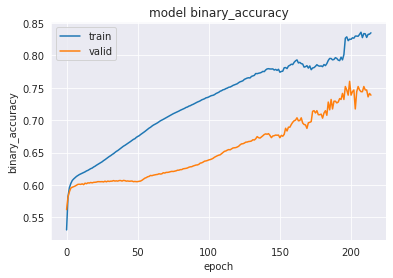

In [36]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


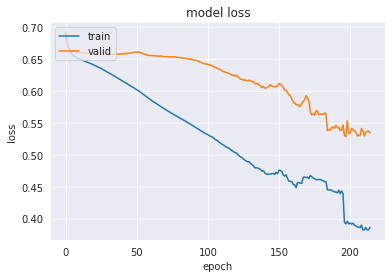

In [37]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [38]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()